#Projeto Aquecimento




Exercício realizado no Bootcamp de Engenharia de Dados da SoulCode

#1.Bibliotecas

##1.1.Instalações de Bibliotecas

In [ ]:
!pip install gcsfs # Necessário para fazer a conexão com a GCP
!pip install pyspark # Necessário para fazer a conexão com o PySpark
!pip install pymongo # Necessário para fazer a conexão com o MongoDB
!pip install pymysql # Necessário para fazer a conexão / envio com o MySQL
!pip install mysql-connector-python # Necessário para fazer a conexão com o MySQL

##1.2.Importação de Bibliotecas 

In [ ]:
from google.cloud import storage
from pymongo import MongoClient
import pymongo
import pandas as pd
import numpy as np
import os
from pyspark import SparkConf
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col
from pyspark.sql.types import DateType
from pyspark.sql.functions import datediff
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col,when
from pyspark.sql import SparkSession # Cria uma sessão no sql
import mysql.connector
from mysql.connector import Error
from pyspark.sql.types import StructField 
from pyspark.sql.types import StructType
from sqlalchemy import create_engine # é responsável por realizar a conexão entre o python/pandas com o MySQL


##1.3.Conectar com Bibliotecas

###1.3.1.GCP

In [ ]:
#Conecção com a GCP
serviceAccount = '/xxxx.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

###1.3.2.Mongo

In [ ]:
#conector do Mongo Atlas
uri = "mongodb+srv:xxxx"
client = MongoClient(uri, 
                     tls=True, 
                     tlsCertificateKeyFile='/xxxx.pem')


###1.3.3.Spark

In [ ]:
#CONFIGURAR A SPARK SESSION
spark = (
   SparkSession.builder
               .master('local')
               .appName('gcsfs') 
               .config('spark.ui.port', '4050')
               .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar') #config acesso conector gcp
               .getOrCreate()                
)
   

#2.Load - Carregamento de dados originais - GCP e MongoDB

##2.1.Carregando os arquivos Brutos para o Bucket

In [ ]:
#Criar DF com arquivos
df_01 = pd.read_csv('/content/D.SDA.PDA.005.CAT.202201.csv', sep=';',encoding = 'ISO-8859-1')
#Enviar arquivo para Bucket
df_01.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202201-ORIGINAL.csv', index=False)

In [ ]:
df_02 = pd.read_csv('/content/D.SDA.PDA.005.CAT.202204.csv', sep=';',encoding = 'ISO-8859-1')
df_02.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202204-ORIGINAL.csv', index=False)

In [ ]:
df_03 = pd.read_csv('/content/D.SDA.PDA.005.CAT.202210.csv', sep=';',encoding = 'ISO-8859-1')
df_03.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202210-ORIGINAL.csv', index=False)

#3.Extract - Extração de dados do data lake

In [ ]:
# DOWLOAND ARQUIVO 1 
df_1 = pd.read_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202201-ORIGINAL.csv')
# DOWLOAND ARQUIVO 2 
df_2 = pd.read_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202204-ORIGINAL.csv')
# DOWLOAND ARQUIVO 3 
df_3 = pd.read_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202210-ORIGINAL.csv')

In [ ]:
#Para mostrar todas as colunas no display
pd.set_option('display.max_columns',25)

##3.1Carregando os arquivos Brutos para o MongoDB

###3.1.1.Tratamento de inconsistências para envio ao MongoDB

####3.1.1.1.Pre Analise para envio

In [ ]:
#Replece de virgulas, espaços, barras e parênteses
df_1.replace(['{', '}','\('],'',regex=True,inplace=True)
df_2.replace(['{', '}','\('],'',regex=True,inplace=True)
df_3.replace(['{', '}','\('],'',regex=True,inplace=True)

In [ ]:
#Dividir o df_2 em dois DF para poder fazer ulpload para Mongo
df_02_parte1 = df_02[0:40001]
df_02_parte2 = df_02[40001:80001]
df_02_parte3 = df_02[80001:89603]

###3.1.2.Carregamento do arquivo o MongoDB

In [ ]:
#Criar conexão
db = client['CAT-PROJETO']

In [ ]:
#Criar e enviar coleção ORIGINAL  
colecao_1 = db['D.SDA.PDA.005.CAT.202201-ORIGINAL']
df1_dict = df_1.to_dict('records')
# Inserindo os dados no mongodb
colecao_1.insert_many(df1_dict)

In [ ]:
colecao_2_parte1 = db['D.SDA.PDA.005.CAT.202204-PARTE1-ORIGINAL']
df2_dict_parte1 = df_02_parte1.to_dict('records')
colecao_2_parte1.insert_many(df2_dict_parte1)

In [ ]:
colecao_2_parte2 = db['D.SDA.PDA.005.CAT.202204-PARTE2-ORIGINAL']
df2_dict_parte2 = df_02_parte2.to_dict('records')
colecao_2_parte2.insert_many(df2_dict_parte2)

In [ ]:
colecao_2_parte3 = db['D.SDA.PDA.005.CAT.202204-PARTE3-ORIGINAL']
df2_dict_parte3 = df_02_parte3.to_dict('records')
colecao_2_parte3.insert_many(df2_dict_parte3)

In [ ]:
colecao_3 = db['D.SDA.PDA.005.CAT.202210-ORIGINAL']
df3_dict = df_3.to_dict('records')
colecao_3.insert_many(df3_dict)

#4.Transform - Tratamento utilizando Pandas e PySpark

##4.1.PANDAS 

###4.1.1.Pre-Analise 

In [ ]:
#Verificar quantidade de linhas e colunas
df_1.shape

(152140, 24)

In [ ]:
#Informações sobre as colunas
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152140 entries, 0 to 152139
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Agente  Causador  Acidente   152140 non-null  object
 1   Data Acidente                152140 non-null  object
 2   CBO                          152140 non-null  object
 3   CID-10                       152140 non-null  object
 4   CNAE2.0 Empregador           152140 non-null  int64 
 5   CNAE2.0 Empregador.1         152140 non-null  object
 6   Emitente CAT                 152140 non-null  object
 7   Espécie do benefício         152140 non-null  object
 8   Filiação Segurado            152140 non-null  object
 9   Indica Óbito Acidente        152140 non-null  object
 10  Munic Empr                   152140 non-null  object
 11  Natureza da Lesão            152140 non-null  object
 12  Origem de Cadastramento CAT  152140 non-null  object
 13  Parte Corpo At

In [ ]:
#Tipos de colunas previmente
df_1.dtypes

Agente  Causador  Acidente     object
Data Acidente                  object
CBO                            object
CID-10                         object
CNAE2.0 Empregador              int64
CNAE2.0 Empregador.1           object
Emitente CAT                   object
Espécie do benefício           object
Filiação Segurado              object
Indica Óbito Acidente          object
Munic Empr                     object
Natureza da Lesão              object
Origem de Cadastramento CAT    object
Parte Corpo Atingida           object
Sexo                           object
Tipo do Acidente               object
UF  Munic.  Acidente           object
UF Munic. Empregador           object
Data Acidente.1                object
Data Despacho Benefício        object
Data Acidente.2                object
Data Nascimento                object
Data Emissão CAT               object
CNPJ/CEI Empregador            object
dtype: object

In [ ]:
#Localiza uma coluna em especifico
df_2.iloc[26604] 

Agente  Causador  Acidente     Rua e Estrada - Superficie Utilizada para Sus
Data Acidente                                                        2022/05
CBO                            371410-Recreador                             
CID-10                         M54.5 Dor Lombar Baixa                       
CNAE2.0 Empregador                                                      8411
CNAE2.0 Empregador.1           Administracao Publica em Geral               
Emitente CAT                                             Empregador         
Espécie do benefício           Pa                                           
Filiação Segurado              Empregado                                    
Indica Óbito Acidente                                                    Não
Munic Empr                         500270-Campo Grande-Ms                   
Natureza da Lesão              Lesao Imediata                               
Origem de Cadastramento CAT                                         Internet

In [ ]:
#Verificação do DF
df_1.head(2)

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,ñ class,2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162


In [ ]:
#Colunas nulas
df_3.isnull().sum()

Agente  Causador  Acidente     0
Data Acidente                  0
CBO                            0
CID-10                         0
CNAE2.0 Empregador             0
CNAE2.0 Empregador.1           0
Emitente CAT                   0
Espécie do benefício           0
Filiação Segurado              0
Indica Óbito Acidente          0
Munic Empr                     0
Natureza da Lesão              0
Origem de Cadastramento CAT    0
Parte Corpo Atingida           0
Sexo                           0
Tipo do Acidente               0
UF  Munic.  Acidente           0
UF Munic. Empregador           0
Data Acidente.1                0
Data Despacho Benefício        0
Data Acidente.2                0
Data Nascimento                0
Data Emissão CAT               0
CNPJ/CEI Empregador            0
dtype: int64

In [ ]:
#Quantidade de itens unicos nas colunas
df_1.nunique()

Agente  Causador  Acidente       294
Data Acidente                      6
CBO                             1523
CID-10                          2932
CNAE2.0 Empregador               809
CNAE2.0 Empregador.1             607
Emitente CAT                       6
Espécie do benefício               5
Filiação Segurado                  4
Indica Óbito Acidente              3
Munic Empr                      2889
Natureza da Lesão                 30
Origem de Cadastramento CAT        2
Parte Corpo Atingida              46
Sexo                               4
Tipo do Acidente                   4
UF  Munic.  Acidente              17
UF Munic. Empregador              28
Data Acidente.1                    6
Data Despacho Benefício            8
Data Acidente.2                  181
Data Nascimento                17628
Data Emissão CAT                  62
CNPJ/CEI Empregador            14662
dtype: int64

In [ ]:
#oreve porcentagem
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
CNAE2.0 Empregador,152140.0,3307.76728,3265.341558,0.0,0.0,2599.0,5320.0,9999.0


In [ ]:
#pARA ACHAR O 0000 DO data
sorted(pd.unique(df_3['Data Acidente.2']))

Concluões iniciais:


--- MODIFICAR USAR ESSA COMO EXPLO
- ENCONTRADA DATA DE NADSCIMENTO 00/00
- CNPJ 000 MUDAR
- COLUNAS DATA ACIDENTE E DATA ACIENDEN 02 REPETINDO 
- MODIFICAR OS TYPOS DAS COLUNAS COM DATAS
- 


###4.1.2.Tratamento

In [ ]:
#Junção dos DataFrames
geral = [df_1,df_2,df_3]
df_geral = pd.concat(geral)

In [ ]:
df_geral.shape

(257401, 24)

In [ ]:
df_geral

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,ñ class,2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,ñ class,Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,ñ class,S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15654,Piso de Edificio - Superficie Utilizada Para,2022/09,ñ class,S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",ñ class,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
15655,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
15656,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas Qualque",Masculino,Típico,ñ class,Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
15657,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150


In [ ]:
#Backap do DF GERAL geral
dfbackgeral_3 = df_geral.copy()

In [ ]:
##DROP de colunas desnecessarias pois é repetitiva em relação a coluna Data nascimento ja existente 

df_geral.drop(['Data Acidente', 'Data Acidente.1'], axis=1, inplace = True)

In [ ]:
#Renomeando as colunas - 

df_geral.rename(columns={'Agente  Causador  Acidente':'Agente_Causador_Acidente',
                         'CBO':'Codigo_Ocupacao',
                         'CID-10':'Identificação_da_doenca',
                         'CNAE2.0 Empregador':'CNAE_COD_Atividade_Economica',
                         'CNAE2.0 Empregador.1':'CNAE_Atividade_Economica',
                         'Emitente CAT':'Emitente_CAT',
                         'Espécie do benefício':'Especie_do_beneficio',
                         'Filiação Segurado':'Filiação_Segurado',
                         'Indica Óbito Acidente':'Indica_Obito_Acidente',
                         'Munic Empr':'Municipio_Empregador',
                         'Origem de Cadastramento CAT':'Origem_Cadastramento_CAT',
                         'Parte Corpo Atingida': 'Parte_Corpo_Atingida',
                         'UF  Munic.  Acidente':'UF_Municipio_Acidente',
                         'UF Munic. Empregador':'UF_Municipio_Empregador',
                         'Data Despacho Benefício':'Data_Despacho_Beneficio',
                         'Data Acidente.2':'Data_Acidente',
                         'Data Nascimento':'Data_Nascimento',
                         'Data Emissão CAT':'Data_Emissao_CAT',                         
                         'CNPJ/CEI Empregador':'CNPJ_Empregador'}, inplace=True)

In [ ]:
#removendo os espaços antes e depois da str
cols = ['Agente_Causador_Acidente',
        'Codigo_Ocupacao',
        'Identificação_da_doenca',
        'CNAE_Atividade_Economica',
        'Emitente_CAT',
        'Especie_do_beneficio',
        'Filiação_Segurado',
        'Indica_Obito_Acidente',
        'Municipio_Empregador',
        'Natureza da Lesão',
        'Origem_Cadastramento_CAT',
        'Parte_Corpo_Atingida',
        'Sexo',
        'Tipo do Acidente',
        'UF_Municipio_Acidente',
        'UF_Municipio_Empregador',
        'CNPJ_Empregador']

for i in cols:
  df_geral[i] = df_geral[i].str.strip()


In [ ]:
#Removendo inconsistência
def to_NaN(DataFrame, name):
    for n in DataFrame:
      DataFrame.replace([name], np.nan,inplace=True)

to_NaN(df_geral,'00.000.000.000.000')
to_NaN(df_geral,'0000/00')
to_NaN(df_geral,'00/00/0000')
to_NaN(df_geral,'ñ class')

In [ ]:
df_geral.dtypes

In [ ]:
#Mudança de tipo das colunas
df_geral['Data_Despacho_Beneficio'] = pd.to_datetime(df_geral['Data_Despacho_Beneficio'], format='%Y/%m')
df_geral['Data_Acidente']= pd.to_datetime(df_geral['Data_Acidente'], dayfirst=True)
df_geral['Data_Nascimento']= pd.to_datetime(df_geral['Data_Nascimento'], dayfirst=True)
df_geral['Data_Emissao_CAT']= pd.to_datetime(df_geral['Data_Emissao_CAT'], dayfirst=True)

##4.2.PYSPARK

In [ ]:
#Enviar arquivo Bruto Geral  para Bucket
df_geral.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.GERAL.csv', index=False)

Montando a estrutura do DataFrame utilizando o StructType
- O objeto StructType é a coleção de objetos StructFields. É um tipo de dados interno que contém a lista de StructField.

In [ ]:
schema = StructType([StructField('Agente_Causador_Acidente',StringType(), True),
                     StructField('Codigo_Ocupacao', StringType(), True),
                     StructField('Identificação_da_doenca',StringType(), True),
                     StructField('CNAE_COD_Atividade_Economica',IntegerType(), True),
                     StructField('CNAE_Atividade_Economica',StringType(), True),
                     StructField('Emitente_CAT',StringType(), True),
                     StructField('Especie_do_beneficio',StringType(), True),
                     StructField('Filiação_Segurado',StringType(), True),
                     StructField('Indica_Obito_Acidente',StringType(), True),
                     StructField('Municipio_Empregador',StringType(), True),
                     StructField('Natureza_da_Lesao',StringType(), True),
                     StructField('Origem_Cadastramento_CAT',StringType(), True),
                     StructField('Parte_Corpo_Atingida',StringType(), True),
                     StructField('Sexo',StringType(), True),
                     StructField('Tipo_do_Acidente',StringType(), True),
                     StructField('UF_Municipio_Acidente',StringType(), True),
                     StructField('UF_Municipio_Empregador',StringType(), True),
                     StructField('Data_Despacho_Beneficio',DateType(),True),
                     StructField('Data_Acidente',DateType(),True),
                     StructField('Data Nascimento',DateType(),True),
                     StructField('Data Emissão CAT',DateType(),True),
                     StructField('CNPJ_Empregador',StringType(), True)                   
                   ])

In [ ]:
#AQUI IREMOS LER O DATAFRAME COLOCANDO INFERSCHEMA COMO FALSE PARA QUE O SPARK NÃO INFIRA O ESQUEMA
# E ADICIONAMOS schema=esquema, PARA UTILIZARMOS O ESQUEMA QUE CRIAMOS ANTERIORMENTE
df = (
    spark.read.format('csv')
              .option('header', 'true')
              .option('inferschema', 'false')
              .option('delimiter', ',')
              .load('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.GERAL.csv', schema = schema)
)

###4.2.1.Pre analise Spark

In [ ]:
df.printSchema()

root
 |-- Agente_Causador_Acidente: string (nullable = true)
 |-- Codigo_Ocupacao: string (nullable = true)
 |-- Identificação_da_doenca: string (nullable = true)
 |-- CNAE_COD_Atividade_Economica: integer (nullable = true)
 |-- CNAE_Atividade_Economica: string (nullable = true)
 |-- Emitente_CAT: string (nullable = true)
 |-- Especie_do_beneficio: string (nullable = true)
 |-- Filiação_Segurado: string (nullable = true)
 |-- Indica_Obito_Acidente: string (nullable = true)
 |-- Municipio_Empregador: string (nullable = true)
 |-- Natureza_da_Lesao: string (nullable = true)
 |-- Origem_Cadastramento_CAT: string (nullable = true)
 |-- Parte_Corpo_Atingida: string (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Tipo_do_Acidente: string (nullable = true)
 |-- UF_Municipio_Acidente: string (nullable = true)
 |-- UF_Municipio_Empregador: string (nullable = true)
 |-- Data_Despacho_Beneficio: date (nullable = true)
 |-- Data_Acidente: date (nullable = true)
 |-- Data Nascimento: dat

In [ ]:
#Verificar se há duplicatas
df.distinct().count()

156630

In [ ]:
df.count()

257401

In [ ]:
#Um OrderBy para mais visualizações
df.orderBy(F.col('CNPJ_Empregador').desc()).show()

+------------------------+--------------------+-----------------------+----------------------------+------------------------+-------------------+--------------------+-----------------+---------------------+--------------------+--------------------+------------------------+--------------------+---------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+------------------+
|Agente_Causador_Acidente|     Codigo_Ocupacao|Identificação_da_doenca|CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica|       Emitente_CAT|Especie_do_beneficio|Filiação_Segurado|Indica_Obito_Acidente|Municipio_Empregador|   Natureza_da_Lesao|Origem_Cadastramento_CAT|Parte_Corpo_Atingida|     Sexo|Tipo_do_Acidente|UF_Municipio_Acidente|UF_Municipio_Empregador|Data_Despacho_Beneficio|Data_Acidente|Data Nascimento|Data Emissão CAT|   CNPJ_Empregador|
+------------------------+--------------------+-----------------------+-------------

In [ ]:
# primeira análise de colunas por ordem crescente e decrescente
df.orderBy(F.col('Data Nascimento').asc()).show()

+------------------------+--------------------+-----------------------+----------------------------+------------------------+------------+--------------------+-----------------+---------------------+--------------------+--------------------+------------------------+--------------------+-------------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+---------------+
|Agente_Causador_Acidente|     Codigo_Ocupacao|Identificação_da_doenca|CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica|Emitente_CAT|Especie_do_beneficio|Filiação_Segurado|Indica_Obito_Acidente|Municipio_Empregador|   Natureza_da_Lesao|Origem_Cadastramento_CAT|Parte_Corpo_Atingida|         Sexo|Tipo_do_Acidente|UF_Municipio_Acidente|UF_Municipio_Empregador|Data_Despacho_Beneficio|Data_Acidente|Data Nascimento|Data Emissão CAT|CNPJ_Empregador|
+------------------------+--------------------+-----------------------+-------------------------

###4.2.2.Tratamento

In [ ]:
# Backup
df_backup = df

In [ ]:
#Renomear uma coluna no Pyspark
df = (df.withColumnRenamed('Natureza da Lesão', 'Naturezada_Lesao')
        .withColumnRenamed('Tipo do Acidente', 'Tipo_do_Acidente'))

In [ ]:
#Remover espeços ainda existentes 
df = df.select([F.trim(F.col(c)).alias(c) for c in df.columns])

In [ ]:
#Retirado do nome Zerado 
df=df.select([when(col(c)=='Zerado',None).otherwise(col(c)).alias(c) for c in df.columns])

In [ ]:
df.show(2)

+------------------------+--------------------+-----------------------+----------------------------+------------------------+-------------------+--------------------+-----------------+---------------------+--------------------+--------------------+------------------------+--------------------+---------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+------------------+
|Agente_Causador_Acidente|     Codigo_Ocupacao|Identificação_da_doenca|CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica|       Emitente_CAT|Especie_do_beneficio|Filiação_Segurado|Indica_Obito_Acidente|Municipio_Empregador|   Natureza_da_Lesao|Origem_Cadastramento_CAT|Parte_Corpo_Atingida|     Sexo|Tipo_do_Acidente|UF_Municipio_Acidente|UF_Municipio_Empregador|Data_Despacho_Beneficio|Data_Acidente|Data Nascimento|Data Emissão CAT|   CNPJ_Empregador|
+------------------------+--------------------+-----------------------+-------------

In [ ]:
# Criando colunas
df2 = (df.withColumn('CNAE', F.concat(F.col('CNAE_COD_Atividade_Economica'), F.lit('-'), F.col('CNAE_Atividade_Economica'))) \
          .withColumn('Quant_dias_Emisao_CAT', F.datediff('Data_Acidente','Data Emissão CAT'))   
       )

In [ ]:
df3 = df \
  .withColumn('CNAE_COD_Atividade_Economica' ,
              df['CNAE_COD_Atividade_Economica']
              .cast(IntegerType()))   

#5.Load - Carregamento de dados Tratados para GCP, MONGODB e MySQL

##5.1.Load - Dataset final Para bucket do CloudStorage

In [ ]:
#transformar de Pypark para PANDAS
df_geral2 = df3.toPandas()

In [ ]:
df_geral2['Data_Despacho_Beneficio']= pd.to_datetime(df_geral2['Data_Despacho_Beneficio'])
df_geral2['Data_Acidente']= pd.to_datetime(df_geral2['Data_Acidente'])
df_geral2['Data Nascimento']= pd.to_datetime(df_geral2['Data Nascimento'])
df_geral2['Data Emissão CAT']= pd.to_datetime(df_geral2['Data Emissão CAT'])

In [ ]:
df_geral2['Data_Despacho_Beneficio']= df_geral2['Data_Despacho_Beneficio'].dt.strftime('%Y-%m-%d %H:%M:%s')
df_geral2['Data_Acidente']= df_geral2['Data_Acidente'].dt.strftime('%Y-%m-%d %H:%M:%s')
df_geral2['Data Nascimento']= df_geral2['Data Nascimento'].dt.strftime('%Y-%m-%d %H:%M:%s')
df_geral2['Data Emissão CAT']= df_geral2['Data Emissão CAT'].dt.strftime('%Y-%m-%d %H:%M:%s')

In [ ]:
df_geral2.to_csv('gs://projeto_cat/TRATADOS/D.SDA.PDA.005.CAT.2022-TRATADOS.csv', index=False)

##5.2.Load - Dataset final Para o MongoDB

In [ ]:
df_geral2_parte1 = df_geral2[0:64350]
df_geral2_parte2 = df_geral2[64350:128700]
df_geral2_parte3 = df_geral2[128700:193050]
df_geral2_parte4 = df_geral2[193050:257401]

In [ ]:
colecao_5_parte1 = db['D.SDA.PDA.005.CAT.20_222-TRATADO-1']
dfmongo1_dict = df_geral2_parte1.to_dict('records')
colecao_5_parte1.insert_many(dfmongo1_dict)

In [ ]:
colecao_6_parte2 = db['D.SDA.PDA.005.CAT.20_222-TRATADO-2']
dfmongo2_dict = df_geral2_parte2.to_dict('records')
colecao_6_parte2.insert_many(dfmongo2_dict)

In [ ]:
colecao_7_parte3 = db['D.SDA.PDA.005.CAT.20_222-TRATADO-3']
dfmongo3_dict = df_geral2_parte3.to_dict('records')
colecao_7_parte3.insert_many(dfmongo3_dict)

In [ ]:
colecao_8_parte4 = db['D.SDA.PDA.005.CAT.20_222-TRATADO-4']
dfmongo4_dict = df_geral2_parte4.to_dict('records')
colecao_8_parte4.insert_many(dfmongo4_dict)

------------------------------------------------

In [ ]:
#Dividir o df_geral2 em dois DF para poder fazer Upload para Mongo
df_geral2_parte1 = df_geral2[0:128701]
df_geral2_parte2 = df_geral2[128701:257401]

In [ ]:
df_geral2_parte1_1 = df_geral2_parte1[0:64350]
df_geral2_parte1_2 = df_geral2_parte1[64350:128701]

In [ ]:
colecao_4_parte1_1 = db['D.SDA.PDA.005.CAT.2022-TRATADO-parte1']
df4_1_1dict = df_geral2_parte1_1.to_dict('records')
colecao_4_parte1_1.insert_many(df4_1_1dict)

In [ ]:
colecao_4_parte1_2 = db['D.SDA.PDA.005.CAT.20_222-TRATADO-parte1_2']
df4_1_2dict = df_geral2_parte1_2.to_dict('records')
colecao_4_parte1_2.insert_many(df4_1_2dict)

In [ ]:
colecao_4_parte2 = db['D.SDA.PDA.005.CAT.2022-TRATADO-parte2']
df4_2_dict = df_geral2_parte2.to_dict('records')
colecao_4_parte2.insert_many(df4_2_dict)

##5.3.Load - Dataset final Para Banco de Dados MySQL.

###5.3.1.Conectar com o Banco de dados

In [ ]:
# dados de para realizar conexão com o servidor
servidor = 'xx.xxx.xxx.x'
nome_do_banco = 'xxxxxx'
usuario = 'xxxx'
senha = 'xxxxxx'

# ciar uma SQLAlchemy engine para conectar com o MySQL 
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=servidor, db=nome_do_banco, user=usuario, pw=senha))

# convertendo dataframe em uma table do sql                                   
df_geral2.to_sql('cat_tratado', engine, index=True, index_label="id")

#6.Insights

##6.1.Pandas

####1 - Quais as profissões que ocorrem mais acidente de trabalho - 

In [ ]:
#Groupby Para descobrir as mais informadas
df_geral.groupby(['Codigo_Ocupacao']).size().sort_values(ascending=False)

Codigo_Ocupacao
000000-Não Informado                            90862
322205-Tec. de Enfermagem                       11824
784205-Alimentador de Linha de Prod.            10582
782510-Motorista de Caminhão Rotas Regionais     4109
717020-Servente de Obras                         3788
                                                ...  
841630-Misturador de Chá ou Mate                    1
841705-Alambiqueiro                                 1
234425-Prof. Fisioterapia                           1
123305-Dir. Comercial                               1
632515-Trab. Exploração de Madeiras Tanantes        1
Length: 1556, dtype: int64

In [ ]:
#Quero que apenas apareça as profissões com mais acidentes
df_geral_sem_nan = df_geral[~df_geral['Codigo_Ocupacao'].isin(["000000-Não Informado"])]

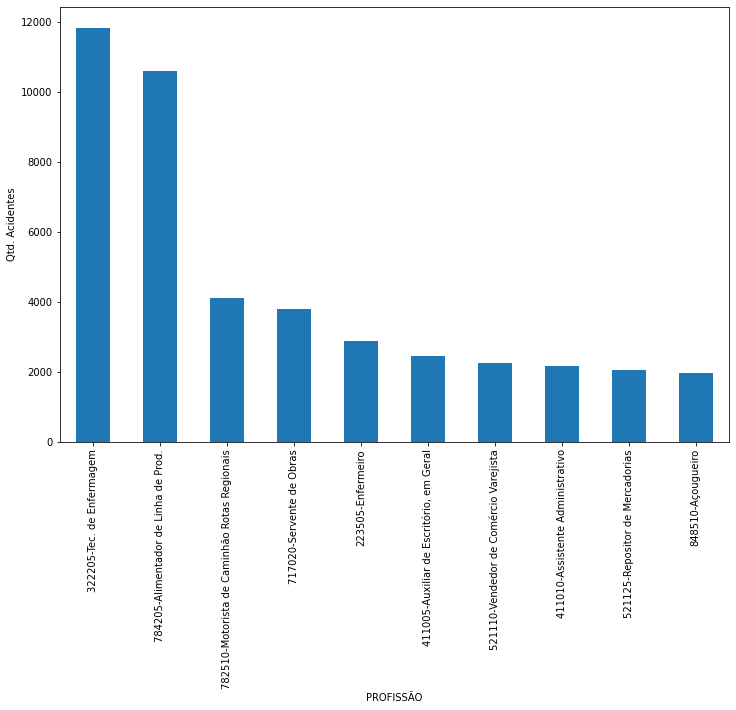

In [ ]:
df_geral_sem_nan.groupby(['Codigo_Ocupacao'],dropna=True).size().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8),xlabel='PROFISSÃO',ylabel='Qtd. Acidentes')

####2 - Em que região ocorre mais acidentes de trabalho? 

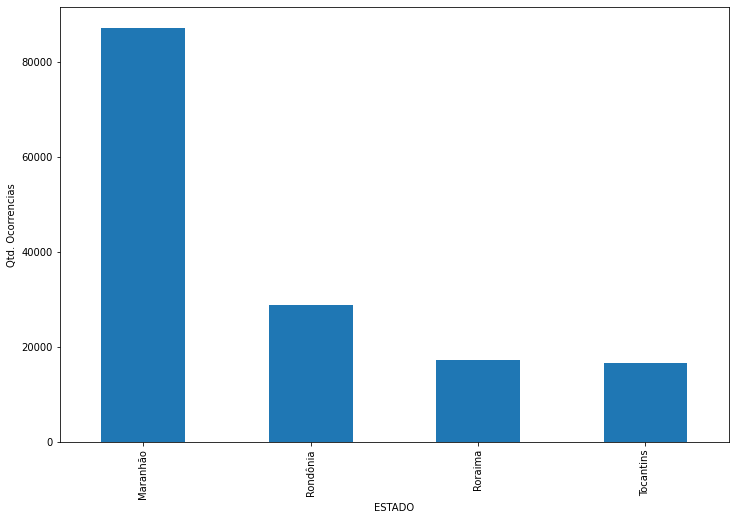

In [ ]:
df_geral.groupby(['UF_Municipio_Acidente'],dropna=True).size().sort_values(ascending=False).head(4).plot.bar(figsize=(12,8),xlabel='ESTADO',ylabel='Qtd. Ocorrencias')

####3 - Quando ocorre mais acidentes. Em que época.

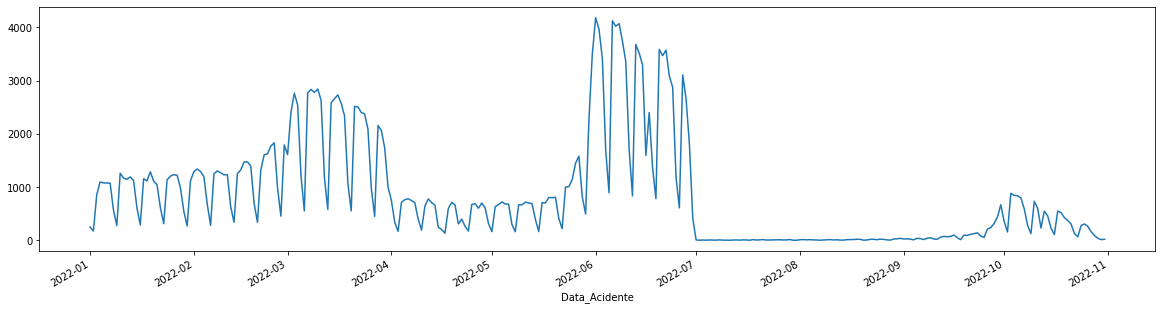

In [ ]:
df_geral.groupby(['Data_Acidente'],dropna=False).size().sort_values(ascending=False).plot.line(figsize=(20,5))

##6.2.PySpark

###6.2.1.Filtros

In [ ]:
#O sexo que mais solicita com o pedido de Auxilio Doença
df.groupBy('Sexo').count().show()

+-------------+------+
|         Sexo| count|
+-------------+------+
|Indeterminado|     3|
|Não Informado|   819|
|     Feminino| 87095|
|    Masculino|169484|
+-------------+------+



In [ ]:
df.filter(F.col('UF_Municipio_Acidente').contains('Alagoas')).show(truncate=False)

In [ ]:
df_geral.dtypes

Agente_Causador_Acidente                object
Codigo_Ocupacao                         object
Identificação_da_doenca                 object
CNAE_COD_Atividade_Economica             int64
CNAE_Atividade_Economica                object
Emitente_CAT                            object
Especie_do_beneficio                    object
Filiação_Segurado                       object
Indica_Obito_Acidente                   object
Municipio_Empregador                    object
Natureza da Lesão                       object
Origem_Cadastramento_CAT                object
Parte_Corpo_Atingida                    object
Sexo                                    object
Tipo do Acidente                        object
UF_Municipio_Acidente                   object
UF_Municipio_Empregador                 object
Data_Despacho_Beneficio         datetime64[ns]
Data_Acidente                   datetime64[ns]
Data_Nascimento                 datetime64[ns]
Data_Emissao_CAT                        object
CNPJ_Empregad

###6.2.2.SparkSQL

In [ ]:
#Criar tabela em tempo de execução para realização de consulta
df3.createOrReplaceTempView("dfsql")

In [ ]:
spark.sql(
    'SELECT * FROM dfsql limit 10;'
).show()

+------------------------+--------------------+-----------------------+----------------------------+------------------------+-------------------+--------------------+-----------------+---------------------+--------------------+--------------------+------------------------+--------------------+---------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+------------------+
|Agente_Causador_Acidente|     Codigo_Ocupacao|Identificação_da_doenca|CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica|       Emitente_CAT|Especie_do_beneficio|Filiação_Segurado|Indica_Obito_Acidente|Municipio_Empregador|   Natureza_da_Lesao|Origem_Cadastramento_CAT|Parte_Corpo_Atingida|     Sexo|Tipo_do_Acidente|UF_Municipio_Acidente|UF_Municipio_Empregador|Data_Despacho_Beneficio|Data_Acidente|Data Nascimento|Data Emissão CAT|   CNPJ_Empregador|
+------------------------+--------------------+-----------------------+-------------

In [ ]:
spark.sql('SELECT Natureza_da_Lesao, Sexo \
           FROM dfsql \
           WHERE Sexo = "Feminino"').show() 

+--------------------+--------+
|   Natureza_da_Lesao|    Sexo|
+--------------------+--------+
|Doenca Contagiosa...|Feminino|
|Doenca Contagiosa...|Feminino|
|Contusao, Esmagam...|Feminino|
|  Outras Lesoes, Nic|Feminino|
|Doenca Contagiosa...|Feminino|
|   Distensao, Torcao|Feminino|
|  Outras Lesoes, Nic|Feminino|
|Escoriacao, Abras...|Feminino|
|Corte, Laceracao,...|Feminino|
|             Fratura|Feminino|
|  Outras Lesoes, Nic|Feminino|
|             Fratura|Feminino|
|Corte, Laceracao,...|Feminino|
|Choque Eletrico e...|Feminino|
|Corte, Laceracao,...|Feminino|
|Contusao, Esmagam...|Feminino|
|   Distensao, Torcao|Feminino|
|Doenca Contagiosa...|Feminino|
|Doenca Contagiosa...|Feminino|
|Doenca Contagiosa...|Feminino|
+--------------------+--------+
only showing top 20 rows



In [ ]:
#qual tipo de acidente é mais comum para cada agente causador?
spark.sql('SELECT Agente_Causador_Acidente, Tipo_do_Acidente, COUNT(Tipo_do_Acidente) \
          FROM dfsql \
          GROUP BY Agente_Causador_Acidente, Tipo_do_Acidente \
          ORDER BY COUNT(Tipo_do_Acidente) DESC').show(10)

+------------------------+----------------+-----------------------+
|Agente_Causador_Acidente|Tipo_do_Acidente|count(Tipo_do_Acidente)|
+------------------------+----------------+-----------------------+
|                    null|        Ignorado|                  90556|
|    Motocicleta, Moto...|         Trajeto|                   7058|
|                    null|          Típico|                   6822|
|    Impacto de Pes. C...|          Típico|                   5024|
|    Metal - Inclui Li...|          Típico|                   4847|
|    Impacto Sofrido p...|          Típico|                   4833|
|    Rua e Estrada - S...|         Trajeto|                   4750|
|    Chao - Superficie...|          Típico|                   4497|
|    Impacto de Pes. C...|          Típico|                   4412|
|    Faca, Facao- Ferr...|          Típico|                   3881|
+------------------------+----------------+-----------------------+
only showing top 10 rows



In [ ]:
#quais ocupações estão mais associadas a determinadas lesões

spark.sql('SELECT Codigo_Ocupacao, Natureza_da_Lesao, COUNT(*) \
          FROM dfsql \
          GROUP BY Codigo_Ocupacao, Natureza_da_Lesao \
          ORDER BY COUNT(*) DESC').show(10)

+--------------------+--------------------+--------+
|     Codigo_Ocupacao|   Natureza_da_Lesao|count(1)|
+--------------------+--------------------+--------+
|000000-Não Informado|                null|   90844|
|                null|             Fratura|    2688|
|784205-Alimentado...|Corte, Laceracao,...|    2656|
|                null|Corte, Laceracao,...|    2640|
|322205-Tec. de En...|      Lesao Imediata|    2182|
|                null|      Lesao Imediata|    2110|
|322205-Tec. de En...|Corte, Laceracao,...|    2092|
|784205-Alimentado...|             Fratura|    1798|
|322205-Tec. de En...|Doenca Contagiosa...|    1689|
|                null|Contusao, Esmagam...|    1679|
+--------------------+--------------------+--------+
only showing top 10 rows



In [ ]:

#Qual é a atividade econômica mais comum entre os acidentados?

spark.sql('SELECT CNAE_Atividade_Economica, \
          COUNT(*) AS Numero_Acidentados\
          FROM dfsql \
          GROUP BY CNAE_Atividade_Economica \
          ORDER BY Numero_Acidentados DESC \
          LIMIT 2').show(10)


+------------------------+------------------+
|CNAE_Atividade_Economica|Numero_Acidentados|
+------------------------+------------------+
|                    null|             96355|
|    Atividades de Ate...|             18129|
+------------------------+------------------+



In [ ]:
#Qual é a relação entre a Natureza da Lesão e a Parte do Corpo Atingida?
spark.sql('SELECT Natureza_da_Lesao, Parte_Corpo_Atingida \
           FROM dfsql \
           GROUP BY Natureza_da_Lesao, Parte_Corpo_Atingida').show(10)


+--------------------+--------------------+
|   Natureza_da_Lesao|Parte_Corpo_Atingida|
+--------------------+--------------------+
|Escoriacao, Abras...|Antebraco Entre O...|
|         Doenca, Nic|         Tronco, Nic|
|Hernia de Qualque...|Abdome Inclusive ...|
|Hernia de Qualque...|Sistema Musculo-E...|
|Asfixia, Estrangu...|Localizacao da Le...|
|    Lesoes Multiplas|Cabeca, Partes Mu...|
|             Fratura|                Coxa|
|Queimadura Quimic...|Braco Entre O Pun...|
|Perda ou Diminuic...|     Sistema Nervoso|
|Perda ou Diminuic...|Boca Inclusive La...|
+--------------------+--------------------+
only showing top 10 rows



###6.2.3.Window Functions

In [ ]:
#CRIAR UMA PARTIÇÃO SOBRE O DATAFRAME PARA UTILIZAR ALGUM TIPO DE CLASSIFICAÇÃO
w00 = Window.partitionBy(F.col('Identificação_da_doenca')).orderBy(F.col('Indica_Obito_Acidente').desc())
# 1) ROW_NUMBER - RETORNA O NÚMERO DA LINHA DE ACORDO COM A PARTIÇÃO CRIADA
df3.withColumn('rank', F.rank().over(w00)).show()

In [ ]:
w1 = Window.partitionBy(F.col('Agente_Causador_Acidente')).orderBy('Especie_do_beneficio')
df3.withColumn('Taxa_de_Acidentes_por_Agente', F.rank().over(w1)).show()

+------------------------+--------------------+-----------------------+----------------------------+------------------------+------------+--------------------+-----------------+---------------------+--------------------+-----------------+------------------------+--------------------+---------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+---------------+----------------------------+
|Agente_Causador_Acidente|     Codigo_Ocupacao|Identificação_da_doenca|CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica|Emitente_CAT|Especie_do_beneficio|Filiação_Segurado|Indica_Obito_Acidente|Municipio_Empregador|Natureza_da_Lesao|Origem_Cadastramento_CAT|Parte_Corpo_Atingida|     Sexo|Tipo_do_Acidente|UF_Municipio_Acidente|UF_Municipio_Empregador|Data_Despacho_Beneficio|Data_Acidente|Data Nascimento|Data Emissão CAT|CNPJ_Empregador|Taxa_de_Acidentes_por_Agente|
+------------------------+--------------------+-----